In [14]:
# import libraries

import torch
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import numpy as np 
import math

import shutil
import os
import time
import sys
from pathlib import Path
import functools
from collections import Counter
print = functools.partial(print, flush=True)

# interest_num = [0,1,2,3,4,5,6,7,8,9]
interest_num = [3,6]
img_size = 32
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1
inference_batch_size = 32
num_f1 = 32
num_f2 = 16
num_f3 = len(interest_num)
init_lr = 0.01


save_to_file = False
if save_to_file:
    sys.stdout = open(save_path+"/log", 'w')
save_path = "./model/"+os.path.basename(sys.argv[0])+"_"+time.strftime("%Y_%m_%d-%H_%M_%S")
Path(save_path).mkdir(parents=True, exist_ok=True)

resume_path = ""
training = True
max_epoch = 10


criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()



print("="*100)
print("Training procedure for Quantum Computer:")
print("\tStart at:",time.strftime("%m/%d/%Y %H:%M:%S"))
print("\tProblems and issues, please contact Dr. Weiwen Jiang (wjiang2@nd.edu)")
print("\tEnjoy and Good Luck!")
print("="*100)
print()

Training procedure for Quantum Computer:
	Start at: 04/27/2020 16:07:01
	Problems and issues, please contact Dr. Weiwen Jiang (wjiang2@nd.edu)
	Enjoy and Good Luck!



In [15]:
def modify_target(target):
    for j in range(len(target)):
        for idx in range(len(interest_num)):
            if target[j] == interest_num[idx]:
                target[j] = idx
                break
    
    new_target = torch.zeros(target.shape[0],2)
        
    for i in range(target.shape[0]):        
        if target[i].item() == 0:            
            new_target[i] = torch.tensor([1,0]).clone()     
        else:
            new_target[i] = torch.tensor([0,1]).clone()
               
    return target,new_target

def select_num(dataset,interest_num):
    labels = dataset.targets #get labels
    labels = labels.numpy()
    idx = {}
    for num in interest_num:
        idx[num] = np.where(labels == num)
        
    fin_idx = idx[interest_num[0]]
    for i in range(1,len(interest_num)):           
        
        fin_idx = (np.concatenate((fin_idx[0],idx[interest_num[i]][0])),)
    
    fin_idx = fin_idx[0]    
    
    dataset.targets = labels[fin_idx]
    dataset.data = dataset.data[fin_idx]
    
    # print(dataset.targets.shape)
    
    dataset.targets,_ = modify_target(dataset.targets)
    # print(dataset.targets.shape)
    
    return dataset




# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor()])
# transform = transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

train_data = select_num(train_data,interest_num)
test_data =  select_num(test_data,interest_num)


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=inference_batch_size, 
    num_workers=num_workers, shuffle=True, drop_last=True)



def save_checkpoint(state, is_best, save_path, filename):
    filename = os.path.join(save_path, filename)
    torch.save(state, filename)
    if is_best:
        bestname = os.path.join(save_path, 'model_best.tar')
        shutil.copyfile(filename, bestname)


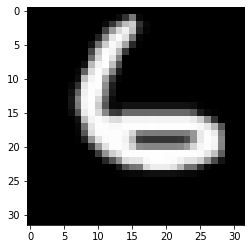

0.0 0.0 0.0 0.0 
0.9019607843137255 0.09411764705882353 0.9882352941176471 0.0 
0.0 0.0 0.5254901960784314 0.0 
0.0 0.0 0.5176470588235295 0.0 


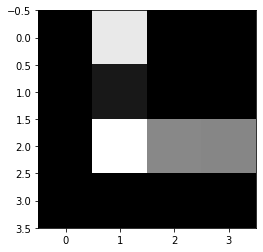

SystemExit: 0

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# functions to show an image
from matplotlib import cm


def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    image = np.asarray(npimg[0] * 255, np.uint8)    
    # image = np.asarray(npimg[0])
    im = Image.fromarray(image,mode="L")
    
    im.save("32*32.jpg",cmap="gray") 
    im = im.resize((4,4))    
    
    for i in range(4):
        for j in range(4):
            print(im.getpixel((i,j))/255,end=" ")
        print()
    plt.imshow(im,cmap='gray',)
    
    plt.show()
    im.save("4*4.jpg",cmap="gray") 
    sys.exit(0)
    

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % filtered_class[labels[j]] for j in range(batch_size)))




In [27]:
from torch.nn.parameter import Parameter
 

class BinarizeF(Function):

    @staticmethod
    def forward(cxt, input):
        output = input.new(input.size())
        output[input >= 0] = 1
        output[input < 0] = -1
        
              
        return output

    @staticmethod
    def backward(cxt, grad_output):
        grad_input = grad_output.clone()
        return grad_input
# aliases
binarize = BinarizeF.apply


class ClipF(Function):

    @staticmethod
    def forward(ctx, input):
        output = input.clone().detach()
        # output = input.new(input.size())
        output[input >= 1] = 1
        output[input <= 0] = 0
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input >= 1] = 0
        grad_input[input <= 0] = 0
        return grad_input


# aliases
clipfunc = ClipF.apply


class BinaryLinear(nn.Linear):
    
    
    def do_slp_via_th(self,input_ori,w_ori):
        p = input_ori
        d = 4*p*(1-p)
        e = (2*p-1)
        # e_sq = torch.tensor(1)
        w = w_ori
        
        sum_of_sq = (d+e.pow(2)).sum(-1)
        sum_of_sq = sum_of_sq.unsqueeze(-1)        
        sum_of_sq = sum_of_sq.expand(p.shape[0], w.shape[0])
                
        diag_p = torch.diag_embed(e)        
        
        p_w = torch.matmul(w,diag_p)
        
        z_p_w = torch.zeros_like(p_w)        
        shft_p_w = torch.cat((p_w, z_p_w), -1)
        
        sum_of_cross = torch.zeros_like(p_w)
        length = p.shape[1]    
        
        for shft in range(1,length):    
            sum_of_cross += shft_p_w[:,:,0:length]*shft_p_w[:,:,shft:length+shft]

        sum_of_cross = sum_of_cross.sum(-1)
                
        return (sum_of_sq+2*sum_of_cross)/(length**2) 
    
    def forward(self, input):        
        binary_weight = binarize(self.weight)        
        if self.bias is None:
            return self.do_slp_via_th(input,binary_weight)
                      
        else:   
            
            bias_one  = torch.ones(input.shape[0],1)            
            new_input = torch.cat((input, bias_one), -1)            
            bias = clipfunc(self.bias).unsqueeze(1)            
            new_weight = binary_weight            
            new_weight = torch.cat((new_weight,bias),-1)                        
            return self.do_slp_via_th(new_input,new_weight)
            
            
            torch.set_printoptions(edgeitems=64)
            # binary_bias = binarize(self.bias)/float(len(input[0].flatten())+1)
            binary_bias = binarize(self.bias)/float(len(input[0].flatten())+1)
            res = F.linear(input, binary_weight/float(len(input[0].flatten())+1), binary_bias)
            return res

    def reset_parameters(self):
        # Glorot initialization
        in_features, out_features = self.weight.size()
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv





class QC_Norm(nn.Module):
    def __init__(self, num_features, momentum=0.1):        
        super(QC_Norm, self).__init__()
        
        self.x_running_rot = Parameter(torch.zeros(num_features),requires_grad=False)        
        self.ang_inc = Parameter(torch.ones(1)*10)
        
        self.momentum = momentum
                
        self.printed = False
        self.x_mean_ancle=0
        self.x_mean_rote = 0
        self.input = 0
        self.output = 0
        
    def forward(self,x,training=True):  
        if not training:
            if not self.printed:
                print("self.ang_inc",self.ang_inc)
                self.printed = True
                    
            x = x.transpose(0,1)
  
            x_ancle = (x*2-1).acos()
            x_final = x_ancle+self.x_running_rot.unsqueeze(-1)
            x_1 = (x_final.cos()+1)/2
                                
            x_1 = x_1.transpose(0,1)
            
        else:
            self.printed = False
            x = x.transpose(0,1)        
            x_sum = x.sum(-1).unsqueeze(-1).expand(x.shape)
            x_lack_sum = x_sum - x    
            x_mean = x_lack_sum/x.shape[-1]
            
            
                    
            x_mean_ancle = (x_mean*2-1).acos()  
            
            ang_inc = self.ang_inc.unsqueeze(-1).expand(x_mean_ancle.shape) 
            # ang_inc = np.pi/2/(x.max(-1)[0].unsqueeze(-1).expand(x_mean_ancle.shape) -x.min(-1)[0].unsqueeze(-1).expand(x_mean_ancle.shape) )
            x_mean_rote = (np.pi/2 - x_mean_ancle)*20 # ang_inc
            
            x_moving_rot = (x_mean_rote.sum(-1)/x.shape[-1])            
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * x_moving_rot
                                                
            x_ancle = (x*2-1).acos()
            x_final = x_ancle+x_mean_rote  
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
      
        return x_1
    
    def reset_parameters(self):
        self.reset_running_stats()
        self.ang_inc.data.zeros_()
        
def print_degree(x,name="x"):
    print(name,x/np.pi*180)
    
    
class QC_Norm_Real(nn.Module):
    def __init__(self,num_features,momentum=0.1):        
        super(QC_Norm_Real, self).__init__()        
        self.x_running_rot = Parameter(torch.zeros(num_features),requires_grad=False)
        self.momentum = momentum
        
        self.x_max = 0
        self.x_min = 0
        # print("Using Normal without real")
        
        
    def forward(self,x,training=True):  
        if not training:
            x = x.transpose(0,1)
            
            x_ancle = (x*2-1).acos()
            # x_final = x_ancle+self.x_running_rot.unsqueeze(-1)  
            x_final = ((x_ancle-self.x_min)/(self.x_max-self.x_min))*np.pi
            
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
            
        else:
            
            x = x.transpose(0,1)        
            x_ancle = (x*2-1).acos()     
            x_rectify_ancle = (x_ancle.max(-1)[0]-x_ancle.min(-1)[0]).unsqueeze(-1).expand(x.shape)                                                                         
            x_final = ((x_ancle-x_ancle.min(-1)[0].unsqueeze(-1))/(x_rectify_ancle))*np.pi
            
            x_moving_rot = x_final - x_ancle
            
            x_moving_rot_mean = x_moving_rot.sum(-1)/x.shape[-1] 
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * x_moving_rot_mean      
            
            self.x_max = self.momentum * x_ancle.max(-1)[0].unsqueeze(-1) + \
                                    (1 - self.momentum) * self.x_max
            self.x_min = self.momentum * x_ancle.min(-1)[0].unsqueeze(-1) + \
                                    (1 - self.momentum) * self.x_min
            
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
            
            
        return x_1


class QC_Norm_Real_Correction(nn.Module):
    def __init__(self,num_features,momentum=0.1):        
        super(QC_Norm_Real_Correction, self).__init__()        
        self.x_running_rot = Parameter(torch.zeros(num_features),requires_grad=False)
        self.momentum = momentum
        
    def forward(self,x,training=True):  
        if not training:
            x = x.transpose(0,1)
            
            x_ancle = (x*2-1).acos()
            x_final = x_ancle+self.x_running_rot.unsqueeze(-1)  
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
            
        else:            
            
            x = x.transpose(0,1)                    
            x_ancle = (x*2-1).acos()                        
            x_moving_rot = -1*(x_ancle.min(-1)[0])
            
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * x_moving_rot                                                    
            x_final = x_ancle+x_moving_rot.unsqueeze(-1)                                    
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
            
            
        
        return x_1

class QC_Norm_Correction(nn.Module):
    def __init__(self,num_features,momentum=0.1):        
        super(QC_Norm_Correction, self).__init__()        
        self.x_running_rot = Parameter(torch.zeros(num_features),requires_grad=False)
        self.momentum = momentum
        
    def forward(self,x,training=True):  
        if not training:
            x = x.transpose(0,1)
            
            x_ancle = (x*2-1).acos()
            x_final = x_ancle+self.x_running_rot.unsqueeze(-1)  
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
            
        else:
            x = x.transpose(0,1)        
            x_sum = x.sum(-1).unsqueeze(-1).expand(x.shape)                
            x_mean = x_sum/x.shape[-1]
                                
            x_mean_ancle = (x_mean*2-1).acos()    
            x_mean_rote = (np.pi/2 - x_mean_ancle) 
            
            x_moving_rot = (x_mean_rote.sum(-1)/x.shape[-1])
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * x_moving_rot                                        
            x_ancle = (x*2-1).acos()
            x_final = x_ancle+x_mean_rote  
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
        
        return x_1

## Define the NN architecture
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
        
        
        
        self.fc1 = BinaryLinear(img_size*img_size,num_f1,bias=False)
        self.fc2 = BinaryLinear(num_f1,num_f2,bias=False)
        self.fc3 = BinaryLinear(num_f2,num_f3,bias=False)
        # # 
        # self.qc1 = QC_Norm(num_features=num_f1)
        # self.qc2 = QC_Norm(num_features=num_f2)
        # self.qc3 = QC_Norm(num_features=num_f3)

        self.qc1a = QC_Norm_Correction(num_features=num_f1)
        self.qc2a = QC_Norm_Correction(num_features=num_f2)
        self.qc3a = QC_Norm_Correction(num_features=num_f3)
        # 
        # 
        self.qc1 = QC_Norm_Real(num_features=num_f1)
        self.qc2 = QC_Norm_Real(num_features=num_f2)
        self.qc3 = QC_Norm_Real(num_features=num_f3)


        # self.qc1a = QC_Norm_Real_Correction(num_features=num_f1)
        # self.qc2a = QC_Norm_Real_Correction(num_features=num_f2)
        # self.qc3a = QC_Norm_Real_Correction(num_features=num_f3)
        # 
    def forward(self, x, training=1):        
        x = x.view(-1, img_size * img_size)
        
        if training == 1:
            # x = binarize(x-0.0001)
            # x = (x+1)/2
            # 
            
            
            # x = self.fc1(x)        
            # x = self.fc2(x)                           
            # x = self.fc3(x)
            # 
            
            x = self.qc1(self.qc1a(self.fc1(x)))        
            x = self.qc2(self.qc2a(self.fc2(x)))                           
            x = self.qc3(self.qc3a(self.fc3(x)))
            # 
            # x = self.qc1((self.fc1(x)))        
            # x = self.qc2((self.fc2(x)))                           
            # x = self.qc3((self.fc3(x)))
            # 
        elif training == 2:
            
            # x = binarize(x-0.0001)
            # x = (x+1)/2
            
            torch.set_printoptions(profile="full")
            
            print(binarize(self.fc1.weight))
            
            
                        
            y = x[0]*binarize(self.fc1.weight[0])
            print(y.sum()/y.shape[0])
            torch.set_printoptions(profile="default")
            x = self.fc1(x)            
            print(x)
        else:
            # x = self.qc1(self.fc1(x),training=False)
            # x = self.qc2(self.fc2(x),training=False)
            # x = self.qc3(self.fc3(x),training=False)
            # 
            
            # x = binarize(x-0.0001)
            # x = (x+1)/2
            # 
            x = self.qc1(self.qc1a(self.fc1(x),training=False),training=False)                
            x = self.qc2(self.qc2a(self.fc2(x),training=False),training=False)            
            x = self.qc3(self.qc3a(self.fc3(x),training=False),training=False)
            # 
            # 
            # x = self.fc1(x)        
            # x = self.fc2(x)                           
            # x = self.fc3(x)
        return x




def train(epoch):
    model.train()
    correct = 0
    epoch_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target,new_target = modify_target(target)
        # 
        # data = (data-data.min())/(data.max()-data.min())
        # data = (binarize(data-0.5)+1)/2
        # 
        
        
        
        data, target = data.to(device), target.to(device)        
        optimizer.zero_grad()
        output = model(data,True)
        
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()    
        
        loss = criterion(output, target)
        epoch_loss.append(loss.item())
        loss.backward()
        
        optimizer.step()
                
        if batch_idx % 100 == 0:        
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}/{} ({:.2f}%)'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss, correct, (batch_idx+1) * len(data),
                100. * float(correct) / float(((batch_idx+1) * len(data)) )))                
    print("-"*20,"training done, loss","-"*20)
    print("Training Set: Average loss: {}".format(round(sum(epoch_loss)/len(epoch_loss),6)))
    
accur=[]
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        target,new_target = modify_target(target)
        
        # 
        # data = (data-data.min())/(data.max()-data.min())
        # data = (binarize(data-0.5)+1)/2
        
        data, target = data.to(device), target.to(device)
        
        # print("Debug")
        # output = model(data,2)
        # 
        # sys.exit(0)
        # data, target = Variable(data, volatile=True), Variable(target)
        output = model(data,False)
        test_loss += criterion(output, target) # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    a=100.*correct / len(test_loader.dataset)
    accur.append(a)  
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * float(correct) / float(len(test_loader.dataset))))
    
    return float(correct) / len(test_loader.dataset)




#Training


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print("="*10,"Model Info","="*10)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
# optimizer = torch.optim.Adam([
#                 {'params': model.fc1.parameters()},
#                 {'params': model.fc2.parameters()},
#                 {'params': model.fc3.parameters()},
#                 {'params': model.qc1.parameters(), 'lr': 1},
#                 {'params': model.qc2.parameters(), 'lr': 1},
#                 {'params': model.qc3.parameters(), 'lr': 1},
#             ], lr=0.1)

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# optimizer = torch.optim.SGD([
#                 {'params': model.fc1.parameters()},
#                 {'params': model.fc2.parameters()},
#                 {'params': model.fc3.parameters()},
#                 {'params': model.qc1.parameters(), 'lr': 1},
#                 {'params': model.qc2.parameters(), 'lr': 1},
#                 {'params': model.qc3.parameters(), 'lr': 1},
#             ], lr=0.1, momentum=0.9)
# 
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, \
#         base_lr=[1e-1,1e-1,1e-1,1,1,1], \
#         max_lr=[1e-3,1e-3,1e-3,1e-2,1e-2,1e-2], \
#         step_size_up=100
#         )

milestones = [3, 5, 8]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

# 
# 
# test()
# 
# 

========== Model Info ==========
Net(
  (fc1): BinaryLinear(in_features=64, out_features=32, bias=False)
  (fc2): BinaryLinear(in_features=32, out_features=16, bias=False)
  (fc3): BinaryLinear(in_features=16, out_features=10, bias=False)
  (qc1): QC_Norm()
  (qc2): QC_Norm()
  (qc3): QC_Norm()
  (qc1a): QC_Norm_Correction()
  (qc2a): QC_Norm_Correction()
  (qc3a): QC_Norm_Correction()
)


In [ ]:
if os.path.isfile(resume_path):
    print("=> loading checkpoint from '{}'<=".format(resume_path))
    checkpoint = torch.load(resume_path, map_location=device)
    epoch_init,acc = checkpoint["epoch"],checkpoint["acc"]
    model.load_state_dict(checkpoint["state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler"])    
    scheduler.milestones = Counter(milestones)
    optimizer.load_state_dict(checkpoint["optimizer"])
else:
    epoch_init,acc = 0,0





if training:
    for epoch in range(epoch_init, max_epoch + 1):
        print("="*20,epoch,"epoch","="*20)  
        print("Epoch Start at:",time.strftime("%m/%d/%Y %H:%M:%S"))        

        print("-"*20,"learning rates","-"*20)
        for param_group in optimizer.param_groups:
            print(param_group['lr'],end=",")
        print()    
        
        print("-"*20,"training","-"*20)
        print("Trainign Start at:",time.strftime("%m/%d/%Y %H:%M:%S"))
        train(epoch)
        print("Trainign End at:",time.strftime("%m/%d/%Y %H:%M:%S"))
        print("-"*60)
        
        print()
        
        
        
        
        
        print("-"*20,"testing","-"*20)
        print("Testing Start at:",time.strftime("%m/%d/%Y %H:%M:%S"))        
        cur_acc = test()
        print("Testing End at:",time.strftime("%m/%d/%Y %H:%M:%S"))
        print("-"*60)
        print()
        
        scheduler.step()
        
        is_best = False
        if cur_acc > acc:
            is_best = True
            acc=cur_acc
        
        print("Best accuracy: {}; Current accuracy {}. Checkpointing".format(acc,cur_acc))
        save_checkpoint({
          'epoch': epoch + 1,
          'acc': acc, 
          'state_dict': model.state_dict(),      
          'optimizer' : optimizer.state_dict(),
           'scheduler': scheduler.state_dict(),
        }, is_best, save_path, 'checkpoint_{}_{}.pth.tar'.format(epoch,round(cur_acc,4)))
        print("Epoch End at:",time.strftime("%m/%d/%Y %H:%M:%S"))
        print("="*60)
        print()        
else:    
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, 
        num_workers=num_workers, shuffle=True, drop_last=True)
    test()
    

==================== 0 epoch ====================
Epoch Start at: 04/22/2020 01:17:24
-------------------- learning rates --------------------
0.01,
-------------------- training --------------------
Trainign Start at: 04/22/2020 01:17:24
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302133	Accuracy: 5/32 (15.62%)
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.152087	Accuracy: 915/3232 (28.31%)
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.167706	Accuracy: 1678/6432 (26.09%)
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.175803	Accuracy: 2520/9632 (26.16%)
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.186147	Accuracy: 3278/12832 (25.55%)
Train Epoch: 0 [16000/60000 (27%)]	Loss: 2.207140	Accuracy: 4008/16032 (25.00%)
